In [1]:
"""
Evaluate a fine-tuned BART model (partial->entire conversation) using BLEU & ROUGE.

Steps:
1) Build partial->entire from CSV
2) Load fine-tuned BART
3) Generate predicted entire conversation from partial
4) Compare with reference entire conversation using BLEU & ROUGE
5) (Optional) visualize BLEU distribution
"""

# Required installations (if needed):
# !pip install nltk evaluate sentencepiece
# import nltk
# nltk.download('punkt')


'\nEvaluate a fine-tuned BART model (partial->entire conversation) using BLEU & ROUGE.\n\nSteps:\n1) Build partial->entire from CSV\n2) Load fine-tuned BART\n3) Generate predicted entire conversation from partial\n4) Compare with reference entire conversation using BLEU & ROUGE\n5) (Optional) visualize BLEU distribution\n'

In [2]:
# =========================================
# 1) Imports
# =========================================
import os
import math
import pandas as pd
import torch

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import evaluate
from transformers import (
    BartTokenizer,
    BartForConditionalGeneration
)

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



c:\Users\DELL\anaconda3\envs\ai-backend\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\DELL\anaconda3\envs\ai-backend\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(



Using device: cpu


In [3]:
# =========================================
# 2) Paths
# =========================================
csv_path = r"C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/FINAL_DATASET2.csv"
model_path = r"C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/bart_partial_entire_model"

partial_ratio = 0.5  # <--- ratio for partial snippet
print("CSV Path:", csv_path)
print("Model Path:", model_path)

CSV Path: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/FINAL_DATASET2.csv
Model Path: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/bart_partial_entire_model


In [4]:
# =========================================
# 3) Build partial->entire from CSV
# =========================================
def build_partial_entire(csv_path, partial_ratio=0.5):
    """
    For each conversation:
      partial snippet = first partial_ratio lines
      entire snippet  = all lines
    Returns list of (partial_str, entire_str)
    """
    df = pd.read_csv(csv_path)
    pairs = []
    for convo_id, group in df.groupby("CONVERSATION_ID"):
        group_sorted = group.sort_values("CONVERSATION_STEP")
        lines = group_sorted["TEXT"].tolist()
        if len(lines) < 2:
            continue

        # entire conversation
        entire_str = "\n".join(lines).strip()

        # partial snippet
        cutoff = max(1, int(len(lines)*partial_ratio))
        partial_lines = lines[:cutoff]
        partial_str = "\n".join(partial_lines).strip()

        if partial_str and entire_str:
            pairs.append((partial_str, entire_str))
    return pairs

pairs = build_partial_entire(csv_path, partial_ratio)
print("Number of partial->entire pairs:", len(pairs))
if pairs:
    print("\nSample pair:\nPartial:", pairs[0][0], "\nEntire:", pairs[0][1])


Number of partial->entire pairs: 76

Sample pair:
Partial: Hello, this is [Your Name]'s personal assistant. How may I assist you today?
Hi, I'm Sam. I saw an ad about a photography workshop hosted by [Org Name] next month. I'm interested in registering but had a few questions.
Hi Sam, it's great to hear of your interest in the photography workshop. I'd be happy to help with any questions you have.
Thanks! I was wondering about the skill level required for participants. I'm fairly new to photography.
The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers. [Org Name] aims to ensure everyone can learn and grow, regardless of their starting point.
That sounds perfect. What's the registration process? 
Entire: Hello, this is [Your Name]'s personal assistant. How may I assist you today?
Hi, I'm Sam. I saw an ad about a photography workshop hosted by [Org Name] next month. I'm interested in registering but had a few questions.
Hi Sam, it's g

In [5]:
# =========================================
# 4) Load Fine-Tuned BART
# =========================================
print("Loading tokenizer and model from:", model_path)
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)
model.to(device)
model.eval()
print("BART model loaded.")


Loading tokenizer and model from: C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/bart_partial_entire_model
BART model loaded.


In [6]:
# =========================================
# 5) Generate Entire Conversation from Partial
# =========================================
def generate_entire_conversation(model, tokenizer, partial_text, max_new_tokens=100, num_beams=4):
    """
    Encodes the partial snippet, uses model.generate to produce entire conversation
    (the model was trained so partial->entire).
    """
    inputs = tokenizer(
        partial_text, 
        return_tensors="pt", 
        truncation=True, 
        max_length=256
    ).to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            early_stopping=True
        )
    gen_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return gen_text


In [7]:
# =========================================
# 6) Evaluate with BLEU & ROUGE
# =========================================
# We'll do sample-level BLEU and store them in a list
# Then we'll do a corpus-level ROUGE with "evaluate" library

rouge_evaluator = evaluate.load("rouge")
smoothing = nltk.translate.bleu_score.SmoothingFunction().method1

bleu_scores = []
predictions = []
references = []

print("Generating & evaluating for each partial->entire pair...")

for i, (partial_str, entire_ref) in enumerate(pairs):
    # 1) Generate entire conversation from partial
    predicted_entire = generate_entire_conversation(model, tokenizer, partial_str)
    
    # store for ROUGE
    predictions.append(predicted_entire)
    references.append(entire_ref)

    # compute sample-level BLEU
    ref_tokens = nltk.word_tokenize(entire_ref.lower())
    hyp_tokens = nltk.word_tokenize(predicted_entire.lower())
    if len(ref_tokens)==0 or len(hyp_tokens)==0:
        bleu = 0.0
    else:
        bleu = sentence_bleu([ref_tokens], hyp_tokens, smoothing_function=smoothing)
    bleu_scores.append(bleu)

# now corpus-level ROUGE
rouge_results = rouge_evaluator.compute(predictions=predictions, references=references)
# typical keys: 'rouge1', 'rouge2', 'rougeL', 'rougeLsum'
rouge1 = rouge_results["rouge1"]
rouge2 = rouge_results["rouge2"]
rougeL = rouge_results["rougeL"]

avg_bleu = np.mean(bleu_scores)

print(f"\n=== Results ===")
print(f"Average BLEU on test set = {avg_bleu:.4f}")
print(f"ROUGE-1 F1 = {rouge1:.4f}")
print(f"ROUGE-2 F1 = {rouge2:.4f}")
print(f"ROUGE-L F1 = {rougeL:.4f}")


Generating & evaluating for each partial->entire pair...

=== Results ===
Average BLEU on test set = 0.1778
ROUGE-1 F1 = 0.5061
ROUGE-2 F1 = 0.4928
ROUGE-L F1 = 0.5035


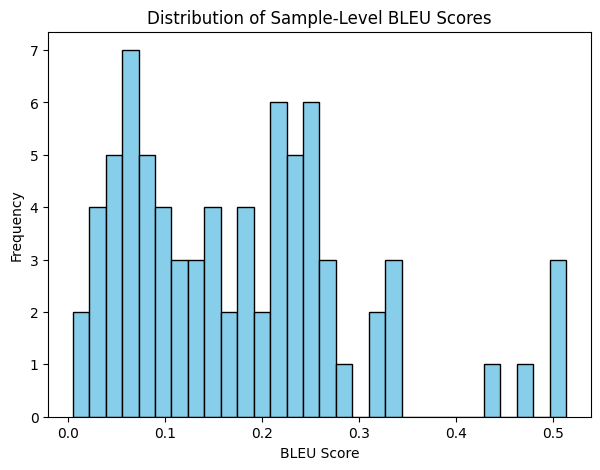

In [8]:
# =========================================
# 7) Visualize BLEU distribution
# =========================================
plt.figure(figsize=(7,5))
plt.hist(bleu_scores, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Sample-Level BLEU Scores")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.show()
